# Implemeting a GPT model from scratch

We will now implement the remaining parts of the LLM

**GPT2 model**

We will continue the steps of this model to start our training.


In [3]:
GPT_CONFIG_124M = {
 "vocab_size": 50257, # Vocabulary size
 "context_length": 1024, # Context length
 "emb_dim": 768, # Embedding dimension
 "n_heads": 12, # Number of attention heads
 "n_layers": 12, # Number of layers
 "drop_rate": 0.1, # Dropout rate
 "qkv_bias": False # Query-Key-Value bias
}

This is the structure we will now follow.

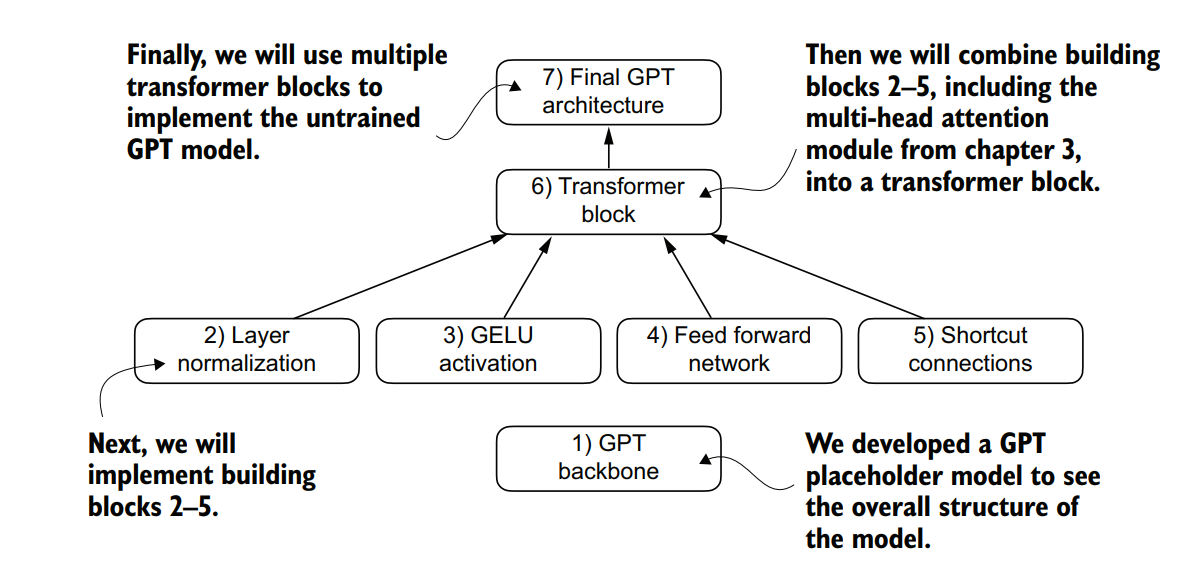

**GPT Backbone**

Simple model to have a quick grasp of what we are dealing with.

In [1]:
import torch
import torch.nn as nn

# Skeleton model
class DummyGPTModel(nn.Module): 
 def __init__(self, cfg): 
    """Initializes components of the model
    cfg: dictionary with model parameters"""

    super().__init__()
    # Embedding input tokens
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])

    # Embedding position tokens
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])

    # Dropout layer for overfitting
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    # Placeholder for transformer blocks
    self.trf_blocks = nn.Sequential(
    *[DummyTransformerBlock(cfg)
    for _ in range(cfg["n_layers"])]
    )
    # Placeholder for LayerNorm
    self.final_norm = DummyLayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(
    cfg["emb_dim"], cfg["vocab_size"], bias=False
    )

 def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape # Shape of input batch
    tok_embeds = self.tok_emb(in_idx) # Token embeddings
    # Position embeddings
    pos_embeds = self.pos_emb(
    torch.arange(seq_len, device=in_idx.device)
    )
    # Combine token and positions
    x = tok_embeds + pos_embeds
    # Apply dropout
    x = self.drop_emb(x)
    # Pass through transformer blocks
    x = self.trf_blocks(x)
    # Apply dummy layer norm
    x = self.final_norm(x)
    # Computes final logits
    logits = self.out_head(x)
    return logits
 
# Skeleton model for transformer block
class DummyTransformerBlock(nn.Module):
 def __init__(self, cfg):
    super().__init__()

 # Does nothing yet, just returns input unchanged
 def forward(self, x):
    return x

# Skeleton model for LayerNorm, final layer normalization
class DummyLayerNorm(nn.Module):
 def __init__(self, normalized_shape, eps=1e-5):
     super().__init__()

 # Does nothing yet, just returns input unchanged
 def forward(self, x):
    return x

In [5]:
# Implementing code to test 
import tiktoken
# Obtain tokens
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0) # Joins the pieces of text
print("Tokenized texts: ",batch)

# Using our previously created dictionary with 124M parameters
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)
# We have two pieces of text ( paragraphs), with 4 tokens each (rows), on 50257 dimensions (columns)

Tokenized texts:  tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


We have obtained a quick view into the GPT architecture as well as its inputs and outputs. 

We will proceed with coding the individual placeholders.

**Dummy Layer Norm**

To do so, we will apply normalizations as they are effective in neural network training as well as stability

The main idea is to fix the activations to a mean 0 and unit variance 1. This speeds up convergence and ensures consistent training.

This is applied before and after the multi-head module.

In [ ]:
# Brief example
torch.manual_seed(123)
batch_example = torch.randn(2, 5) # Random tensor of 2x5 following a normal distribution
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU()) # Sequential model of Linear and ReLU activation
# ReLU activation swtiches negative values with 0s
out = layer(batch_example) # Applies model to current example
print("Output tensor: ",out)

# Mean and variance before normalization
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

# Mean and variance after normalizaiton
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
torch.set_printoptions(sci_mode= False) # Avoids scientific notation
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Output tensor:  tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)
Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)
Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [10]:
# Implementing this in a model
class LayerNorm(nn.Module):
 def __init__(self, emb_dim): # emb_dim is the last dimension, to work with these numbers
    super().__init__()
    self.eps = 1e-5 # Small value to avoid division by 0
    # Trainable parameters
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))
    
 def forward(self, x):
    # Applies normalization
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)
    norm_x = (x - mean) / torch.sqrt(var + self.eps)
    return self.scale * norm_x + self.shift

In [11]:
# Testing our code
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


**GELU activation function**

Gausian Error Linear Unit

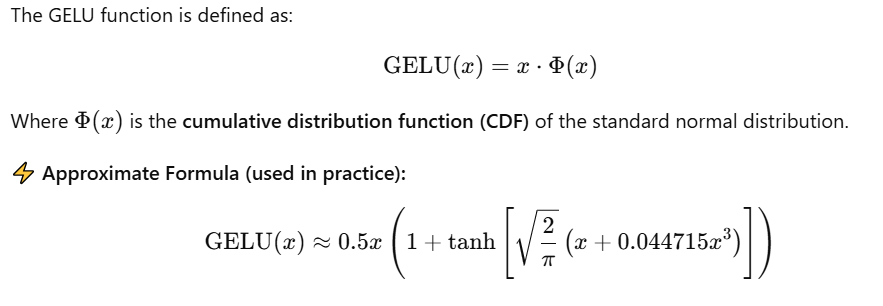


Smooth and differentiable

In [12]:
# GELU code
class GELU(nn.Module):
 def __init__(self):
    super().__init__()
    
 def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
    torch.sqrt(torch.tensor(2.0 / torch.pi)) *
    (x + 0.044715 * torch.pow(x, 3))
    ))

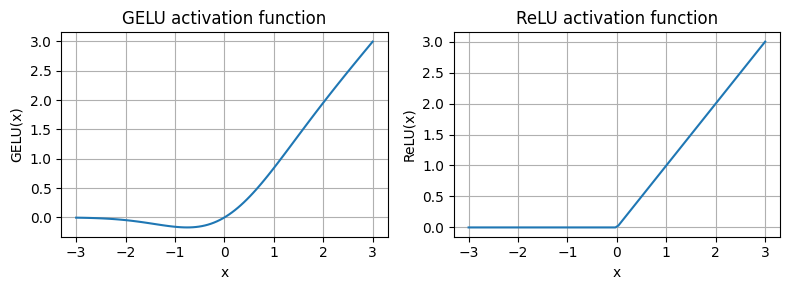

In [ ]:
# Comparing GELU and RELU
import matplotlib.pyplot as plt

# Initializing the functions
gelu, relu = GELU(), nn.ReLU()

# 100 data samples from -3 to 3
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))


for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
 plt.subplot(1, 2, i)
 plt.plot(x, y)
 plt.title(f"{label} activation function")
 plt.xlabel("x")
 plt.ylabel(f"{label}(x)")
 plt.grid(True)
plt.tight_layout()
plt.show()


We can see the kink ReLu has at 0, contrary to the smoothness of GELU. This makes it easier for optimization, moreover, it also allows negative values.

In [15]:
# Small NN to be used later
class FeedForward(nn.Module):
 def __init__(self, cfg):
    super().__init__()
    # Neural layers
    self.layers = nn.Sequential(
    nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), # Increases embedding by 4
    GELU(),
    nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), # Decreases embedding by 4
    )
 def forward(self, x):
    return self.layers(x)
 
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


The FeedForward module changes the embedding size midway through this process, in this way, efficiency and performance is enhanced without drastically affecting parameters or memory. It allows for non linearities, and maintains the same input output structure.

**Shortcut Connections**

Created to deal with vanishing gradients

Shortcut connections creates alternative paths for the gradient to flow through the network by skipping layers. DOne by adding output of one layer to the output of a later layer.

They dont omit layers, they just add layers.

In [ ]:
# Brief example
class ExampleDeepNeuralNetwork(nn.Module):
 def __init__(self, layer_sizes, use_shortcut):
    super().__init__()
    self.use_shortcut = use_shortcut
    # Creates 5 layers
    self.layers = nn.ModuleList([nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]),
 GELU()),
 nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]),
 GELU()),
 nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]),
 GELU()),
 nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]),
 GELU()),
 nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]),
 GELU())
 ])

 def forward(self, x):
    for layer in self.layers:
        layer_output = layer(x) # Compute the layer output
        if self.use_shortcut and x.shape == layer_output.shape: # See if shortcut can be done
            x = x + layer_output
        else:
            x = layer_output
    return x
 
# NN with no shortcuts
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]]) # 1x3 input tensor fed into the model
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
 layer_sizes, use_shortcut=False
)


# Function for computing the gradient
def print_gradients(model, x):
 output = model(x)
 target = torch.tensor([[0.]])

 # Calcualtes the loss
 loss = nn.MSELoss()
 loss = loss(output, target)

 # Calculates the gradients
 loss.backward()

 for name, param in model.named_parameters():
    if 'weight' in name:
        print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

# Gradients of our previous example
print_gradients(model_without_shortcut, sample_input)

# We can see our gradients keep getting smaller, phenomenom called the vanishing gradient problem

# Model with skip connections
torch.manual_seed(123)
print("Skip connections model")
model_with_shortcut = ExampleDeepNeuralNetwork(
 layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)
# Gradients seem to stabilize

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041653171182
layers.3.0.weight has gradient mean of 0.001398873864673078
layers.4.0.weight has gradient mean of 0.005049646366387606
Skip connections model
layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732502937317
layers.4.0.weight has gradient mean of 1.3258541822433472


**Connecting layers in a transformer block**

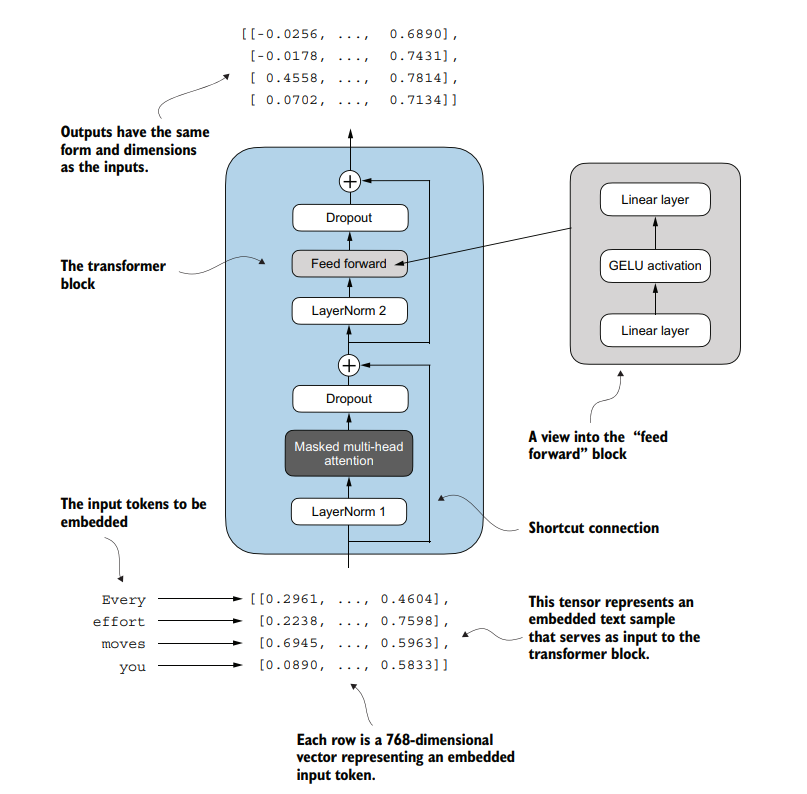

In [24]:
from chapter03 import MultiHeadAttention

class TransformerBlock(nn.Module):
 def __init__(self, cfg):
    super().__init__()
    """Init method
        d_in = input embedding size
        d_out = output embedding size
        context_length = max number of tokens in a sentence
        num_heads = number of heads to use 
        dropout = droput rate
        qkv_bias = whether to add bias"""
    self.att = MultiHeadAttention(
    d_in=cfg["emb_dim"],
    d_out=cfg["emb_dim"],
    context_length=cfg["context_length"],
    num_heads=cfg["n_heads"],
    dropout=cfg["drop_rate"],
    qkv_bias=cfg["qkv_bias"])

    # FeedForward structure
    self.ff = FeedForward(cfg)

    # Normalizes inputs before the different blocks <- PreLayerNorm
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])

    # Dropout layer
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
 
 def forward(self, x): # Enables shortcut connections

    # FIrst block of our previously shown picture
    shortcut = x
    x = self.norm1(x) # Normalize input
    x = self.att(x) # Self-attention
    x = self.drop_shortcut(x) # Dropout
    x = x + shortcut # Residual connection 

    # Second block
    shortcut = x
    x = self.norm2(x) # Normalize
    x = self.ff(x) # FeedForward    
    x = self.drop_shortcut(x) # Dropout
    x = x + shortcut # Residual 
    return x

In [ ]:
# Testing the previous model
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M) # Creates the object
output = block(x) # Obtains the output
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


**GPT Model**

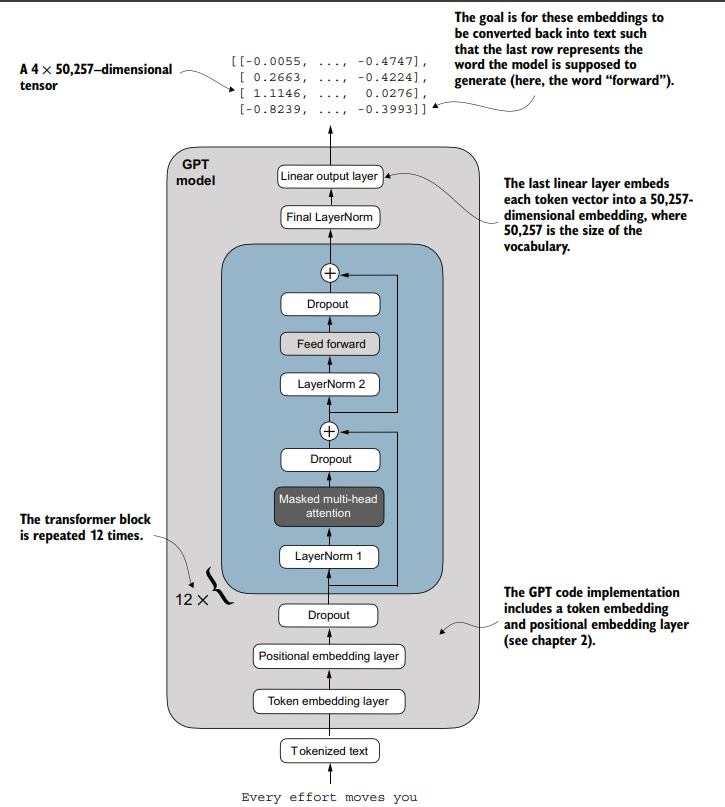

In [26]:
class GPTModel(nn.Module):
 def __init__(self, cfg):
    super().__init__()
    # Token and positional embedding layers, convert tokens into vectors and add valuable information
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    # Sequential Stack of Transformer Block equal to the number of layers
    self.trf_blocks = nn.Sequential(
    *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

    # Layer Norm to standardize outputs
    self.final_norm = LayerNorm(cfg["emb_dim"])

    # Output into the vocabulary
    self.out_head = nn.Linear(
    cfg["emb_dim"], cfg["vocab_size"], bias=False
    )

 def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    # Computes embeddings
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(
    torch.arange(seq_len, device=in_idx.device)
    )
    # Adds embeddings
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x) # Dropout
    x = self.trf_blocks(x) # Transformer Blocks
    x = self.final_norm(x) # Normalization
    logits = self.out_head(x) # Output
    return logits

In [29]:
# Testing
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)


Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


In [ ]:
# More intel
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}") # Number differs to the stated due to weight typing, GPT2 reuses weights from token embeddings
# Weight typing is reusing weights as input and output layers generally use the same set of weights.
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

# Removing output layer parameters c
total_params_gpt2 = (
 total_params - sum(p.numel()
 for p in model.out_head.parameters())
)
print(f"Number of trainable parameters "
 f"considering weight tying: {total_params_gpt2:,}"
)

# Memory requirements
total_size_bytes = total_params * 4 # Assume 4 bytes per parameter 32 bit float
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total number of parameters: 163,009,536
Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])
Number of trainable parameters considering weight tying: 124,412,160
Total size of the model: 621.83 MB


**Generating text**

We already have our output tokens, we just need to decode it.

For predicitng the next word, the model generates the next token given its input, each step, there is a matrix with vectors representing the potential next tokens.

These values are switched to probabilities using a softmax , the index with the highest value translates to the token ID.

It then appends the selected token to the input for the next word.

In [32]:
# Simple function
def generate_text_simple(model, idx,
    max_new_tokens, context_size):
 # Uses only the maximum amount of selected tokens
 for _ in range(max_new_tokens):
    idx_cond = idx[:, -context_size:] # Takes the selected tokens as input
    with torch.no_grad(): # No gradient calculating (prediction)
        logits = model(idx_cond) # Output prediction 

    logits = logits[:, -1, :] # Logits for the last token (predicting the last wrod)
    probas = torch.softmax(logits, dim=-1) # Values to probabilities (softmax) not strictly necessary
    idx_next = torch.argmax(probas, dim=-1, keepdim=True) # Selects the highest value
    idx = torch.cat((idx, idx_next), dim=1) # Appends to the previous tokens
 return idx

In [35]:
# Testing our code
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

# Prediction
model.eval() # Avoids dropout
out = generate_text_simple(
 model=model,
 idx=encoded_tensor,
 max_new_tokens=6,
 context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print("Decoded text: ",decoded_text)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])
Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10
Decoded text:  Hello, I am Featureiman Byeswickattribute argue


Does not provide a reasonable output as we have yet to train it.

**Summary**

 Layer normalization stabilizes training by ensuring that each layer’s outputs
have a consistent mean and variance.

 Shortcut connections are connections that skip one or more layers by feeding
the output of one layer directly to a deeper layer, which helps mitigate the vanishing gradient problem when training deep neural networks, such as LLMs.

 Transformer blocks are a core structural component of GPT models, combining masked multi-head attention modules with fully connected feed forward
networks that use the GELU activation function.

 GPT models are LLMs with many repeated transformer blocks that have millions to billions of parameters.

 GPT models come in various sizes, for example, 124, 345, 762, and 1,542 million parameters, which we can implement with the same GPTModel Python class.

 The text-generation capability of a GPT-like LLM involves decoding output tensors into human-readable text by sequentially predicting one token at a time
based on a given input context.

 Without training, a GPT model generates incoherent text, which underscores
the importance of model training for coherent text generation.